In [2]:
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions

import skimage.io
import skimage.segmentation

import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression

import copy
import warnings

np.random.seed(42)
keras.__version__

'3.11.2'

In [3]:
warnings.filterwarnings('ignore')
model = keras.applications.inception_v3.InceptionV3()

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 27s 0us/step


-0.9979664118227225 1.0


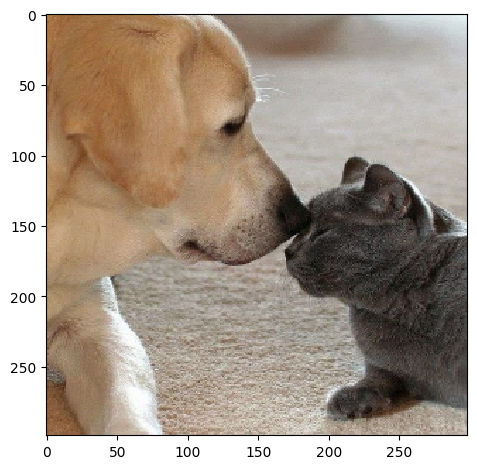

In [6]:
im = skimage.io.imread("cat-and-dog.jpg")
im = skimage.transform.resize(im, (299,299))

im = (im - 0.5)*2  # model's preprocessing, makes it in [-1, 1]
print(im.min(), im.max())

skimage.io.imshow(im/2 + 0.5)  # [-1, 1] -> [-0.5, 0.5] -> [0, 1]

In [7]:
preds = model.predict(im[None,...])
decode_predictions(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step


[[('n02099712', 'Labrador_retriever', np.float32(0.8182908)),
  ('n02099601', 'golden_retriever', np.float32(0.015929852)),
  ('n02093428', 'American_Staffordshire_terrier', np.float32(0.010066439)),
  ('n02108422', 'bull_mastiff', np.float32(0.009287026)),
  ('n02109047', 'Great_Dane', np.float32(0.0086010005))]]

In [14]:
# argsort() gives array of indexes, sorted based on values (logits)
top5 = preds[0].argsort()[-5:][::-1]
top5

array([208, 207, 180, 243, 246])

# LIME Steps

## 1 - Perturbations

Get superpixels by Quickshift clustering <br>
Will be used to mask the image

In [15]:
superpixels = skimage.segmentation.quickshift(im, kernel_size=4, max_dist=200, ratio=0.2)
n_sp = np.unique(superpixels).shape[0]
n_sp

71

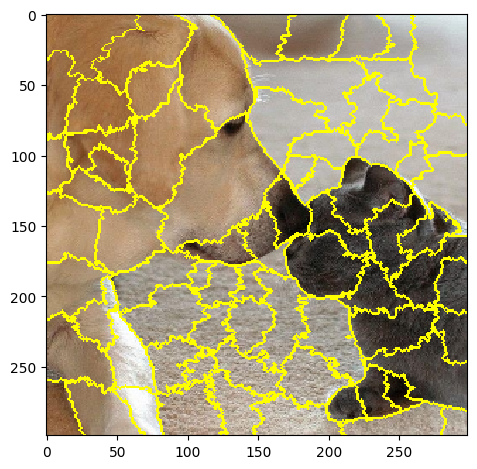

In [16]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(im/2+0.5, superpixels))

Mask the image using subset of superpixels <br>
Subset is based on binomial distribution

In [25]:
n_perturb = 150
perturbs = np.random.binomial(1, 0.5, (n_perturb, n_sp))
perturbs[0]

array([1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1], dtype=int32)

In [18]:
def perturb_img(im, perturbs, segments):
    active_px = np.where(perturbs == 1)[0]
    mask = np.zeros_like(segments)

    for active in active_px:
        mask[segments == active] = 1
    
    perturbed = copy.deepcopy(im)
    perturbed = perturbed * mask[...,None]
    
    return perturbed

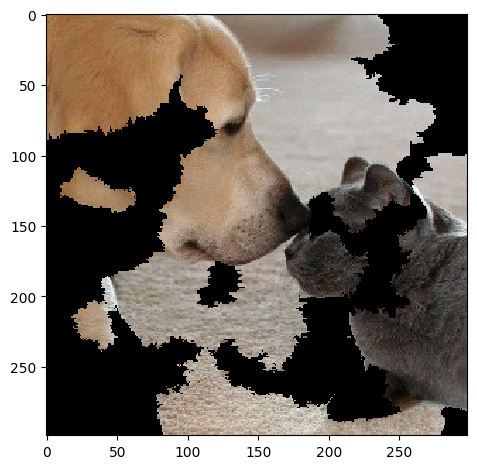

In [26]:
skimage.io.imshow(perturb_img(im/2+0.5, perturbs[0], superpixels))